# Validating SARG04

### Distance Graph
- Vary distance parameter in `QuantumChannel` class
- Measure throughputs using `n1.protocol_stack[0]`

### Secret/Sifted
- Call `QKDNode.update_lightsource_params` to change `mean_photon_num` to some desired value
- measure throughputs as before

> NOTE: To switch between algorithms, you must manually go into the `src/topology/node.py` file and change the algorithm that's used from BB84 to SARG04.

In [1]:
from ipywidgets import interact
from matplotlib import pyplot as plt
import time
import math

from sequence.kernel.timeline import Timeline
from sequence.kernel.event import Event
from sequence.kernel.process import Process
from sequence.topology.node import QKDNode
from sequence.components.optical_channel import QuantumChannel, ClassicalChannel
from sequence.qkd.SARG04 import pair_sarg04_protocols
from sequence.qkd.BB84 import pair_bb84_protocols

In [2]:
class KeyManager():
    def __init__(self, timeline, keysize, num_keys):
        self.timeline = timeline
        self.lower_protocols = []
        self.keysize = keysize
        self.num_keys = num_keys
        self.keys = []
        self.times = []
        
    def send_request(self):
        for p in self.lower_protocols:
            p.push(self.keysize, self.num_keys) # interface for BB84 to generate key
            
    def pop(self, info): # interface for BB84 to return generated keys
        self.keys.append(info)
        self.times.append(self.timeline.now() * 1e-9)

## Testing Distance

Measure Secret Key Rate (kbit/s) vs Distance (km)

In [3]:
def test_distance(sim_time, keysize, distance):
    """
    sim_time: duration of simulation time (ms)
    keysize: size of generated secure key (bits)
    """
    # begin by defining the simulation timeline with the correct simulation time
    tl = Timeline(sim_time * 1e9)
    
    # Here, we create nodes for the network (QKD nodes for key distribution)
    # stack_size=1 indicates that only the BB84 protocol should be included
    n1 = QKDNode("n1", tl, stack_size=1)
    n2 = QKDNode("n2", tl, stack_size=1)
    #detector_params = [{"efficiency": 0.8, "dark_count": 10, "time_resolution": 10, "count_rate": 50e6},
    #               {"efficiency": 0.8, "dark_count": 10, "time_resolution": 10, "count_rate": 50e6}]
    #detector_params = [{"efficiency": 0.4}]
    n1.set_seed(0)
    n2.set_seed(1)

    from sequence.components.detector import QSDetector, QSDetectorPolarization
    print(f"n2.components.values(): {n2.components.values()}")
    for component in n2.components.values():
        if type(component) is QSDetectorPolarization:
            component.detectors[0].efficiency = 0.4
            component.detectors[1].efficiency = 0.4
            print(f"[ DEBUG ] c1 : {component.detectors[0].efficiency}")
            print(f"[ DEBUG ] c2 : {component.detectors[1].efficiency}")

    pair_bb84_protocols(n1.protocol_stack[0], n2.protocol_stack[0])
    
    # connect the nodes and set parameters for the fibers
    # note that channels are one-way
    # construct a classical communication channel
    # (with arguments for the channel name, timeline, and length (in m))
    cc0 = ClassicalChannel("cc_n1_n2", tl, distance=distance)
    cc1 = ClassicalChannel("cc_n2_n1", tl, distance=distance)
    cc0.set_ends(n1, n2.name)
    cc1.set_ends(n2, n1.name)
    # construct a quantum communication channel
    # (with arguments for the channel name, timeline, attenuation (in dB/km), and distance (in m))

    # F = (1+V)/2
    # Reported visibility is ~0.953
    qc0 = QuantumChannel("qc_n1_n2", tl, attenuation=3e-4, distance=distance,
                         polarization_fidelity=(1+0.97)/2)
    qc1 = QuantumChannel("qc_n2_n1", tl, attenuation=3e-4, distance=distance,
                         polarization_fidelity=(1+0.97)/2)
    qc0.set_ends(n1, n2.name)
    qc1.set_ends(n2, n1.name)
    
    # instantiate our written keysize protocol
    km1 = KeyManager(tl, keysize, 25)
    km1.lower_protocols.append(n1.protocol_stack[0])
    n1.protocol_stack[0].upper_protocols.append(km1)
    km2 = KeyManager(tl, keysize, 25)
    km2.lower_protocols.append(n2.protocol_stack[0])
    n2.protocol_stack[0].upper_protocols.append(km2)
    
    # start simulation and record timing
    tl.init()
    km1.send_request()
    tick = time.time()
    tl.run()
    #print("execution time %.2f sec" % (time.time() - tick))
    
    return n1.protocol_stack[0].throughputs
    # display our collected metrics
    # plt.plot(km1.times, range(1, len(km1.keys) + 1), marker="o")
    # plt.xlabel("Simulation time (ms)")
    # plt.ylabel("Number of Completed Keys")
    # plt.show()
    
    # print("key error rates:")
    # for i, e in enumerate(n1.protocol_stack[0].error_rates):
    #     print("\tkey {}:\t{}%".format(i + 1, e * 100))

n2.components.values(): dict_values([<sequence.components.light_source.LightSource object at 0x7f1916c1b130>, <sequence.components.detector.QSDetectorPolarization object at 0x7f1916c1b010>])
[ DEBUG ] c1 : 0.4
[ DEBUG ] c2 : 0.4
950.0:	[1186558.549800006, 1333333.3750000014, 1333333.3750000014, 1333333.3750000014, 1333333.3750000014, 1333333.3750000014, 1333333.3750000014, 1600000.0500000017, 1333333.3750000014, 1333333.3750000014, 1333333.3750000014, 1600000.0500000017, 1333333.3750000014, 1333333.3750000014, 1333333.3750000014, 1600000.0500000017, 1600000.0500000017, 1333333.3750000014, 1333333.3750000014, 1333333.3750000014, 1600000.0500000017, 1333333.3750000014, 1600000.0500000017, 1600000.0500000017, 1333333.3750000014]
n2.components.values(): dict_values([<sequence.components.light_source.LightSource object at 0x7f19168f23b0>, <sequence.components.detector.QSDetectorPolarization object at 0x7f19168f0520>])
[ DEBUG ] c1 : 0.4
[ DEBUG ] c2 : 0.4
1300.0:	[1140311.8344849488, 133333

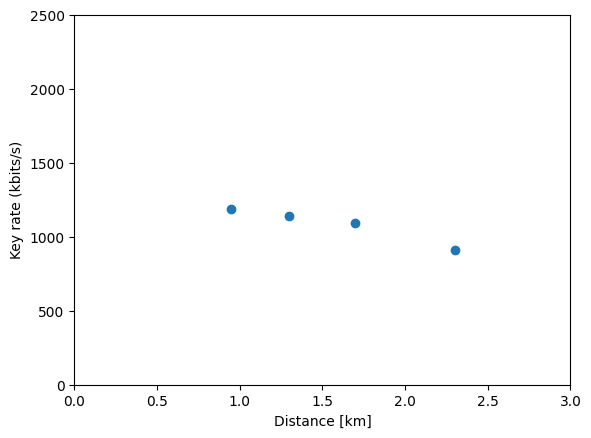

In [4]:
# Create and run the simulation
# interactive_plot = interact(test_distance, sim_time=(100, 1000, 100), keysize=[128, 256, 512])
# interactive_plot
from numpy import mean

distances = [950.0, 1300.0, 1700.0, 2300.0]
key_rates = []
for d in distances:
    throughputs = test_distance(sim_time=100, keysize=256, distance=d)
    print(f"{d}:\t{throughputs}")
    key_rates.append(mean(throughputs[0]))

fig = plt.figure()
print(distances)
print(key_rates)
plt.scatter([d/1000 for d in distances], [k/1000 for k in key_rates])
plt.xlim([0, 3.0])
plt.ylim([0, 2500])
plt.xlabel("Distance [km]")
plt.ylabel("Key rate (kbits/s)")
plt.show()

## Testing Secret vs Sift Key Rate
key rate (kbit/s) vs average photon number (meu)

In [ ]:
def test_sift(sim_time, keysize, average_photon_number):
    """
    sim_time: duration of simulation time (ms)
    keysize: size of generated secure key (bits)
    """
    # begin by defining the simulation timeline with the correct simulation time
    tl = Timeline(sim_time * 1e9)
    
    # Here, we create nodes for the network (QKD nodes for key distribution)
    # stack_size=1 indicates that only the BB84 protocol should be included
    n1 = QKDNode("n1", tl, stack_size=1)
    n1.update_lightsource_params("mean_photon_num", average_photon_number)
    n1.update_lightsource_params("frequency", 1e6)
    
    n2 = QKDNode("n2", tl, stack_size=1)
    n2.update_lightsource_params("mean_photon_num", average_photon_number)
    n2.update_lightsource_params("frequency", 1e6)
    #detector_params = [{"efficiency": 0.8, "dark_count": 10, "time_resolution": 10, "count_rate": 50e6},
    #               {"efficiency": 0.8, "dark_count": 10, "time_resolution": 10, "count_rate": 50e6}]
    # detector_params = [{"efficiency": 0.1}, {"efficiency": 0.1}]
    
    n1.set_seed(0)
    n2.set_seed(1)

    from sequence.components.detector import QSDetector, QSDetectorPolarization
    print(f"n2.components.values(): {n2.components.values()}")
    for component in n2.components.values():
        if type(component) is QSDetectorPolarization:
            component.detectors[0].efficiency = 0.4
            component.detectors[1].efficiency = 0.4
            print(f"[ DEBUG ] c1 : {component.detectors[0].efficiency}")
            print(f"[ DEBUG ] c2 : {component.detectors[1].efficiency}")



    # for i in range(len(detector_params)):
    #     for name, param in detector_params[i].items():
    #         n2.update_detector_params(i, name, param)

    #pair_bb84_protocols(n1.protocol_stack[0], n2.protocol_stack[0])
    pair_sarg04_protocols(n1.protocol_stack[0], n2.protocol_stack[0])
    
    # connect the nodes and set parameters for the fibers
    # note that channels are one-way
    # construct a classical communication channel
    # (with arguments for the channel name, timeline, and length (in m))
    cc0 = ClassicalChannel("cc_n1_n2", tl, distance=1270)
    cc1 = ClassicalChannel("cc_n2_n1", tl, distance=1270)
    cc0.set_ends(n1, n2.name)
    cc1.set_ends(n2, n1.name)
    #cc0.delay += 1e9  # 1 ms
    #cc1.delay += 1e9
    
    # construct a quantum communication channel
    # (with arguments for the channel name, timeline, attenuation (in dB/km), and distance (in m))
    # prev attenuation val: 1e-5
    qc0 = QuantumChannel("qc_n1_n2", tl, attenuation=3e-4, distance=1270,
                         polarization_fidelity=0.97)
    qc1 = QuantumChannel("qc_n2_n1", tl, attenuation=3e-4, distance=1270,
                         polarization_fidelity=0.97)
    qc0.set_ends(n1, n2.name)
    qc1.set_ends(n2, n1.name)
    
    # instantiate our written keysize protocol
    km1 = KeyManager(tl, keysize, 25)
    km1.lower_protocols.append(n1.protocol_stack[0])
    n1.protocol_stack[0].upper_protocols.append(km1)
    km2 = KeyManager(tl, keysize, 25)
    km2.lower_protocols.append(n2.protocol_stack[0])
    n2.protocol_stack[0].upper_protocols.append(km2)
    
    # process = Process(n1.protocol_stack[0], "push", [256, math.inf, 6e12])
    # event = Event(0, process)
    
    # start simulation and record timing
    #tl.schedule(event)
    tl.init()
    km1.send_request()
    tick = time.time()
    tl.run()
    #print("execution time %.2f sec" % (time.time() - tick))

    return n1.protocol_stack[0].throughputs
    # display our collected metrics
    # plt.plot(km1.times, range(1, len(km1.keys) + 1), marker="o")
    # plt.xlabel("Simulation time (ms)")
    # plt.ylabel("Number of Completed Keys")
    # plt.show()
    
    # print("key error rates:")
    # for i, e in enumerate(n1.protocol_stack[0].error_rates):
    #     print("\tkey {}:\t{}%".format(i + 1, e * 100))

In [ ]:
# Create and run the simulation
#interactive_plot = interact(test_sift, sim_time=(100, 1000, 100), keysize=[128, 256, 512])
#interactive_plot
from numpy import mean
key_rates = []
mean_photons = [0.03, 0.06, 0.09, 0.13, 0.16, 0.19, 0.25, 0.28]
mean_photons = [x/2 for x in mean_photons]
for m in mean_photons:
    throughputs = test_sift(sim_time=10000, keysize=256, average_photon_number=m)
    print(f"{m}: {throughputs}")
    key_rates.append(mean(throughputs[0]))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
print(mean_photons)
print(key_rates)
bars = ax.bar([str(2*x) for x in mean_photons], [x/1000 for x in key_rates])
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{round(height, 2)}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')


#plt.ylim([0,40])
plt.xlabel("Average Photon Number (μ)")
plt.ylabel("Key rate (kbits/s)")
plt.title("Sifted keys [kbits/s] vs Mean Photon")
plt.show()